# Imports iniciais

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
from PIL import Image
from scipy import ndimage as ndi

from skimage.morphology import watershed, binary_closing, binary_opening, binary_erosion, binary_dilation, erosion
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu, sobel, laplace, gaussian, median

# Funções auxiliares

In [73]:
def list_plot(im_list, title_list, figsize=(20, 10), cmap=None, ax_on=False):
    # Plot a list of image with titles
    fig, axis = plt.subplots(1, len(im_list), figsize=figsize)
    for i in range(len(im_list)):
        if isinstance(cmap, list):
            c = cmap[i]
        else:
            c = cmap
        axis[i].imshow(im_list[i], cmap=c)
        axis[i].set_title(title_list[i])
        if not ax_on:
            axis[i].set_axis_off()

def plot_histogram(f, nbins, title='', color='b'):
    h, bin_edges = np.histogram(f, nbins,(0,180))
    # Plot
    w=255./nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure()
    plt.bar(bin_centers, h, width=w, color=color)
    plt.title(title)
    
# normalize images to specified range
def normalize(f, range=(0,255)):
    # normalize to 0,1 first
    f = (f - np.min(f)) / (np.max(f) - np.min(f))
    # set to specified range
    f = (f + np.min(range)) * (np.max(range) - np.min(range))
    return f

def shuffle_labels(labels):
    u = np.unique(labels)
    idx = labels == 0
    np.random.shuffle(u)
    out = u[labels] + 1
    out[idx] = 0
    return out

def make_gif(images, path, add_color=True, cmap='gnuplot'):
    cm = matplotlib.cm.get_cmap(cmap)
    if add_color:
        images = [cm(normalize(im).astype(int)) for im in images]
    imageio.mimsave(path, images)

---

# Implementação própria (Watershed sem marcadores)

A implementação do algorítimo `watershed` sem marcadores ocorre iterativamente inundando os pixels de menor valor da imagem até que todos os pixels sejam inundados. Caso ocorra a mistura de dois `catchment basins` (rótulos diferentes) uma fronteira/barreira é criada entre eles usando operações morfológicas (dilatação). 

A cada iteração utiliza-se a função `label` do pacote `scipy` para identificar os `catchment basin` (regiões conexas na imagem). Em seguida, calcula-se a intersecção de cada elemento $q$ encontrado na iteração $N$ com a imagem inundada da iteração anterior $N-1$. A intersecção, por sua vez, também pode ser rotulada em elementos contínuos e total de elementos $c$ definem o próximo passo do algorítimo.
* Caso $c = 0$: Como não ha intercção do elemento da iteração $N$ com a imagem inundada $N-1$ significa que $q$ é seu próprio `catchement basin`. Ou seja $q$ que recebe um novo rotulo.
* Caso $c = 1$: Significa que a intersecção é o próprio elemento $q$ na iteração anterior, i.e. a região esta aumentando e mantém-se o rotulo de $q$.
* Caso $c > 0$: Como agora existe mais de 1 elemento contínuo na interceção de $q$ em $N$ com a imagem inundada em $N-1$, significa que dois elementos se fundiram e a criação de uma barreira se faz necessário.


In [3]:
def custom_watershed(image, verbose=False, return_intermediate=False):
    im = normalize(image.copy()).astype(int)
    unique_values = np.unique(im)
    kernel = np.ones((5,5))
    structure = np.ones((3,3))
    out = []
    for i in range(len(unique_values)):
        if not i:
            continue
    
        labels = ndi.label(im < unique_values[i], structure)[0]
        if return_intermediate:
            out.append(labels)
        prev_step = im < unique_values[i-1]
        for l in np.unique(labels):
            if not l:
                continue
            q = labels == l
            overlap = ndi.label(q & prev_step, structure)[0]
            u_overlap = np.unique(overlap)
            count = len(u_overlap) - 1

            if count == 0:
                if verbose:
                    print('New object found')
            elif count == 1:
                if verbose:
                    print('Increasing region')
            elif count > 1:
                if verbose:
                    print('Objects merged, constructing dam')
                dam = np.zeros_like(im)
                for d in u_overlap:
                    if not d:
                        continue
                    qi = overlap == d
                    dam += binary_dilation(qi, kernel)
                im[dam > 1] = np.max(im) + 1
    if return_intermediate:
        return ndi.label(im < 255)[0], out
    else:
        return ndi.label(im < 255)[0]

---

# Exemplo em uma imagem sintética binária

## Criação da imagem sintética

Text(0.5,1,'Image sintética criada')

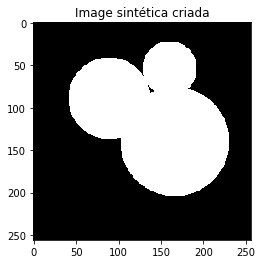

In [111]:
x, y = np.indices((256, 256))
x1, y1 = 89, 89
x2, y2 = 140, 166
x3, y3 = 54, 160

r1, r2, r3 = 48, 64, 32
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
mask_circle3 = (x - x3)**2 + (y - y3)**2 < r3**2
image = np.logical_or(mask_circle1, mask_circle2)
image = np.logical_or(image, mask_circle3)

plt.imshow(image, cmap='gray')
plt.title('Image sintética criada')

## Transformação de imagem binária para relevo
Para transformar a imagem binária em uma imagem em tons de cinzas análoga a um relevo, utiliza-se a transformada de distância.
Nota-se que tal transformada forma morros e picos ou invés de vales (`basins`), desta forma utiliza-se a imagem transformada multiplicada por -1.

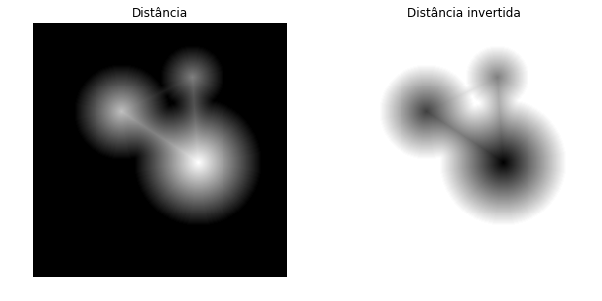

In [112]:
distance = ndi.distance_transform_edt(image)
list_plot([distance, -distance], 'Distância_Distância invertida'.split('_'), cmap='gray', figsize=(10,5))

## Watershed
Uma vez que a imagem é transformada em uma imagem "relevo", é possivel aplicar a função `watershed`. Nota-se como os objetos tiveram sua borda na intersecção transformada em barragem.

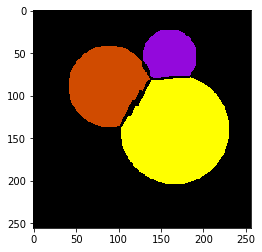

In [113]:
seg_im = custom_watershed(-distance)
plt.imshow(seg_im, cmap='gnuplot')

![SegmentLocal](circles2.gif "segment")

---

# Exemplo foto em tons de cinza
Esse exemplo é uma foto da microestrutura de um aço. Os "ladrilhos" são os grãos do material enquanto as divisões em tons mais escuros são o contorno de grão onde o carbono fica difundido no material. 

Text(0.5,1,'Imagem RGB')

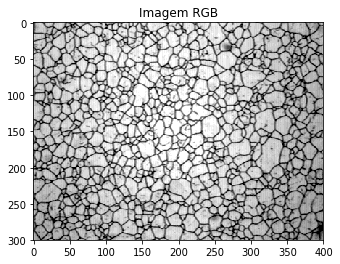

In [69]:
gray_im = np.asarray(Image.open('metal.jpg').convert('L'))
plt.imshow(gray_im, cmap='gray')
plt.title('Imagem RGB')

## Limiarização
A partir da imagem em tons de cinza facilmente pode-se obter uma imagem binária usando um valor de limiar.

Text(0.5,1,'Imagem binária')

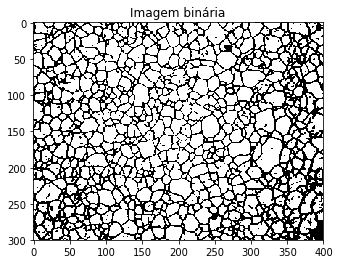

In [70]:
T = 150
bin_im = gray_im > T
plt.imshow(bin_im, cmap='gray')
plt.title('Imagem binária')

## Transformada de distância
É possível aplicar a transformada de distância na imagem binária para obter a imagem "relevo".

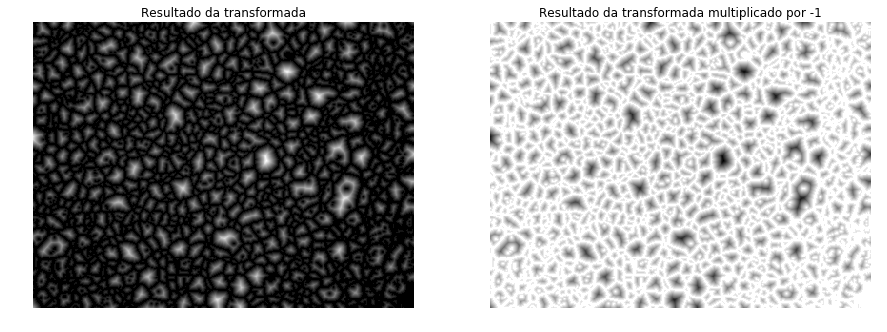

In [71]:
distance = ndi.distance_transform_edt(bin_im)
list_plot([distance, -distance],
          'Resultado da transformada_Resultado da transformada multiplicado por -1'.split('_'),
          cmap='gray', figsize=(15, 7))

## Watershed
Aplica-se a função `watershed` no negativo da imagem "relevo" e conta-se o total de rotulos encotrados para identificar o número de objetos na imagem. 

1256 objetos encontrados.


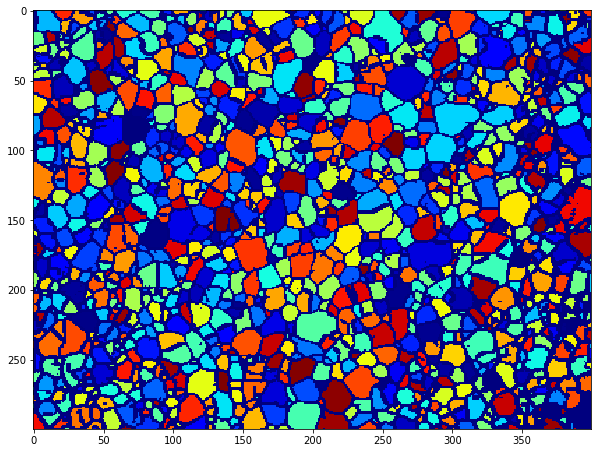

In [77]:
seg_im = custom_watershed(-distance)
plt.figure(figsize=(10, 10))
plt.imshow(shuffle_labels(seg_im), cmap='jet')
print('{} objetos encontrados.' .format(len(np.unique(seg_im))))

![SegmentLocal](metal.gif "segment")

---

# Exemplo foto real (RGB)

Primeiro abre-se a foto original e converte-se para HSV (será aplicado uma limiarização no canal de saturação)

Text(0.5,1,'Imagem RGB')

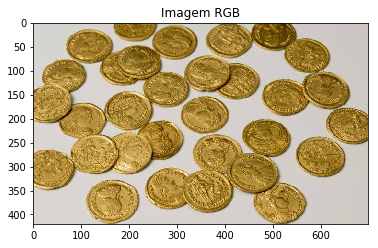

In [78]:
image = Image.open('moedas.jpg')
hsv_im = np.asarray(image.convert('HSV'))
gray_im = np.asarray(image.convert('L'))
plt.imshow(image)
plt.title('Imagem RGB')

## Segmentação da imagem como um todo

Visualiza-se os histogramas dos três canais da imagem.

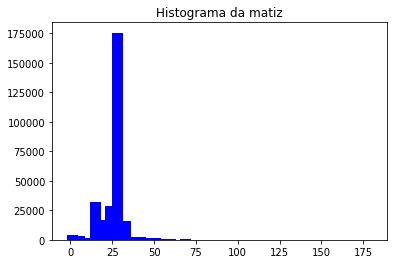

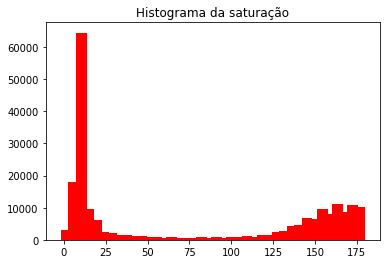

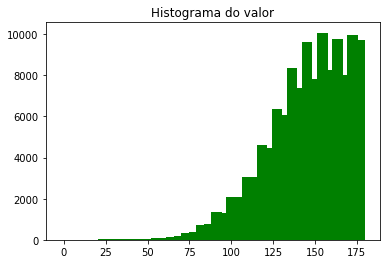

In [79]:
plot_histogram(hsv_im[:, :, 0], 40, 'Histograma da matiz', color='b')
plot_histogram(hsv_im[:, :, 1], 40, 'Histograma da saturação', color='r')
plot_histogram(hsv_im[:, :, 2], 40, 'Histograma do valor', color='g')

Nota-se claramente uma distribuição quase bimodal no histograma da saturação. Pode-se aproveitar tal fato para realizar uma limiarização na imagem a partir deste canal.

Text(0.5,1,'Imagem binária depois da limiarização')

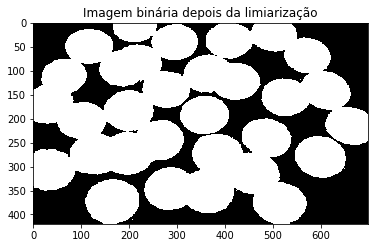

In [80]:
threshold = 40
bin_im = hsv_im[:, :, 1] > threshold
plt.imshow(bin_im, cmap='gray')
plt.title('Imagem binária depois da limiarização')

## Watershed
Executa-se o procedimento análogo ao demais exemplos e obtém-se a imagem segmentada.

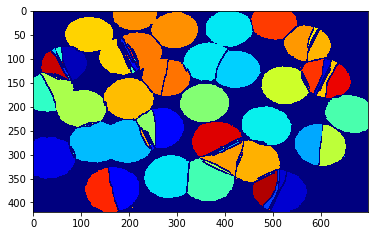

In [83]:
distance = ndi.distance_transform_edt(bin_im)
seg_im = custom_watershed(-distance)
plt.imshow(shuffle_labels(seg_im), cmap='jet')

Nota-se que ocorreu um processo de `oversegmentation`. Isto ocorre devido a minimos locais existentes em uma imagem real.

![SegmentLocal](moedas.gif "segment")

---

---

# Watershed com marcadores

# Exemplo binário
## Geração da imagem sintética

Text(0.5,1,'Image sintética criada')

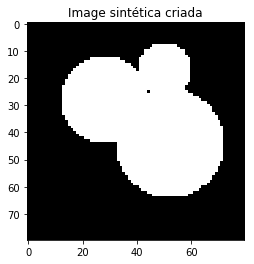

In [18]:
x, y = np.indices((80, 80))
x1, y1 = 28, 28
x2, y2 = 44, 52
x3, y3 = 17, 50

r1, r2, r3 = 16, 20, 10
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
mask_circle3 = (x - x3)**2 + (y - y3)**2 < r3**2
image = np.logical_or(mask_circle1, mask_circle2)
image = np.logical_or(image, mask_circle3)

plt.imshow(image, cmap='gray')
plt.title('Image sintética criada')

## Criando os marcadores
Primeiro transforma-se a imagem binária em uma imagem em tons de cinza usando a transformada de distância. Desta forma, cada pixel fica com seu valor proporcional a sua distância ao background.
Depois, procura-se os máximos locais na imagem de distâncias.

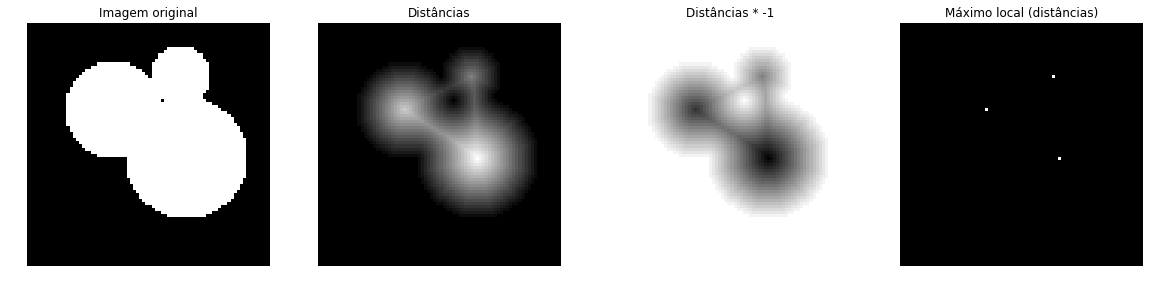

In [19]:
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)),
                            labels=image)

im_list = [image, distance, -distance, local_maxi]
title_list = 'Imagem original_Distâncias_Distâncias * -1_Máximo local (distâncias)'.split('_')
list_plot(im_list, title_list, cmap='gray')

## Watershed
Finalmente, identifica-se cada máximo local como um `label` e aplica-se o algorítimo `watershed`.

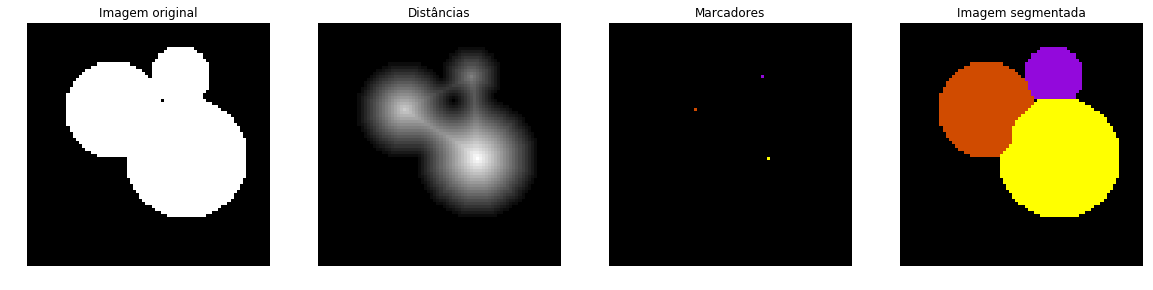

In [20]:
markers = ndi.label(local_maxi)[0]
seg_im = watershed(-distance, markers, mask=image)

im_list = [image, distance, markers, seg_im]
title_list = 'Imagem original_Distâncias_Marcadores_Imagem segmentada'.split('_')
cmap_list = ['gray', 'gray', 'gnuplot', 'gnuplot']
list_plot(im_list, title_list, cmap=cmap_list)

---

# Exemplo foto em tons de cinza
Esse exemplo é uma foto da microestrutura de um aço. Os "ladrilhos" são os grãos do material enquanto as divisões em tons mais escuros são o contorno de grão onde o carbono fica difundido no material. 

Text(0.5,1,'Imagem RGB')

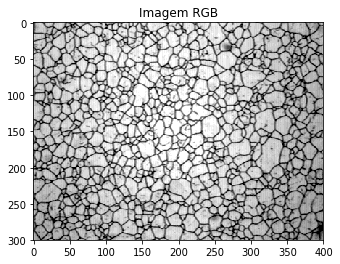

In [21]:
gray_im = np.asarray(Image.open('metal.jpg').convert('L'))
plt.imshow(gray_im, cmap='gray')
plt.title('Imagem RGB')

## Limiarização
A partir da imagem em tons de cinza facilmente pode-se obter uma imagem binária usando um valor de limiar.

Text(0.5,1,'Imagem binária')

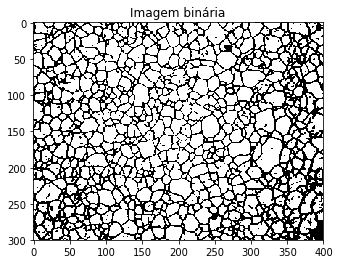

In [22]:
T = 150
bin_im = gray_im > T
plt.imshow(bin_im, cmap='gray')
plt.title('Imagem binária')

### Criação dos marcadores e segmentação dos objetos
Agora usa-se a transformada de distâncias para criar a imagem relevo a partir da imagem binária. Apartir do resultado, o algoritimo de busca de picos locais é usado para criar os marcadores. Finalmente os objetos são segmentados usando o algorítimo de `watershed` no inverso das distâncias com auxilio dos marcadores.

865 objetos localizados.


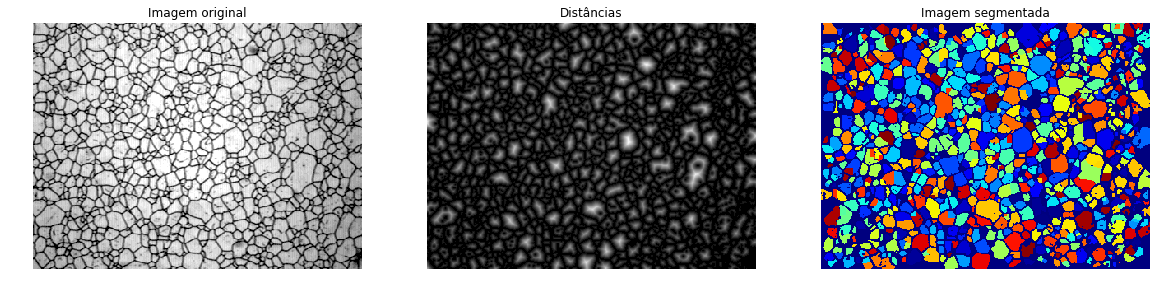

In [23]:
distance = ndi.distance_transform_edt(bin_im)
kernel = 10
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel, kernel)))
markers = ndi.label(local_maxi)[0]
seg_im = watershed(-distance, markers, mask=bin_im)
im_list = [gray_im, distance, shuffle_labels(seg_im)]
title_list = 'Imagem original_Distâncias_Imagem segmentada'.split('_')
cmap_list = ['gray', 'gray', 'jet', 'jet']
list_plot(im_list, title_list, figsize=(20, 20), cmap=cmap_list)
print('{} objetos localizados.'.format(len(np.unique(seg_im))) )

---

# Exemplo foto real (RGB)

Primeiro abre-se a foto original e converte-se para HSV (será aplicado uma limiarização no canal de saturação)

Text(0.5,1,'Imagem RGB')

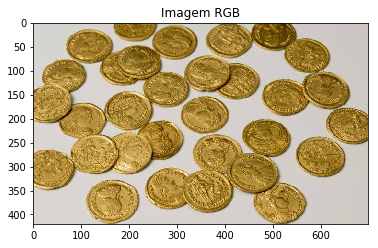

In [24]:
image = Image.open('moedas.jpg')
hsv_im = np.asarray(image.convert('HSV'))
gray_im = np.asarray(image.convert('L'))
plt.imshow(image)
plt.title('Imagem RGB')

## Segmentação da imagem como um todo

Visualiza-se os histogramas dos três canais da imagem.

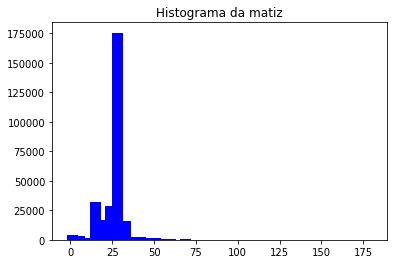

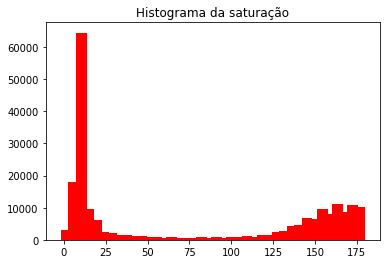

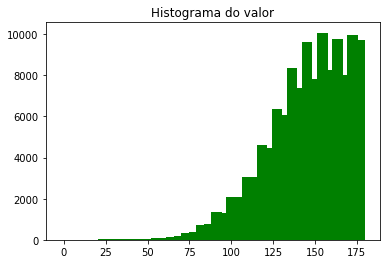

In [25]:
plot_histogram(hsv_im[:, :, 0], 40, 'Histograma da matiz', color='b')
plot_histogram(hsv_im[:, :, 1], 40, 'Histograma da saturação', color='r')
plot_histogram(hsv_im[:, :, 2], 40, 'Histograma do valor', color='g')

Nota-se claramente uma distribuição quase bimodal no histograma da saturação. Pode-se aproveitar tal fato para realizar uma limiarização na imagem a partir deste canal.

Text(0.5,1,'Imagem binária depois da limiarização')

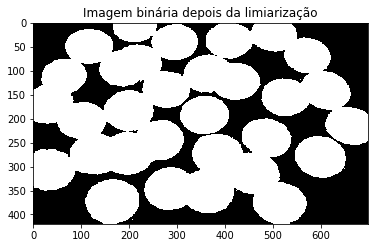

In [26]:
threshold = 40
bin_im = hsv_im[:, :, 1] > threshold
plt.imshow(bin_im, cmap='gray')
plt.title('Imagem binária depois da limiarização')

### Criação dos marcadores e segmentação dos objetos
Agora usa-se a transformada de distâncias para criar a imagem relevo a partir da imagem binária. Apartir do resultado, o algoritimo de busca de picos locais é usado para criar os marcadores. Finalmente os objetos são segmentados usando o algorítimo de `watershed` no inverso das distâncias com auxilio dos marcadores.

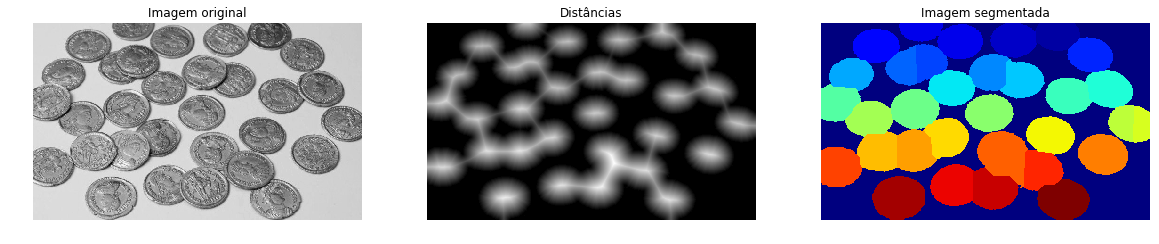

In [27]:
distance = ndi.distance_transform_edt(bin_im)
kernel = 15
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((kernel, kernel)))
markers = ndi.label(local_maxi)[0]
seg_im = watershed(-distance, markers, mask=bin_im)
im_list = [gray_im, distance, seg_im]
title_list = 'Imagem original_Distâncias_Imagem segmentada'.split('_')
cmap_list = ['gray', 'gray', 'jet', 'jet']
list_plot(im_list, title_list, figsize=(20, 20), cmap=cmap_list)

Contando os valores únicos da imagem segmentada é possível contar o número de objetos encotrados

31 objetos identificados de um total de 32.


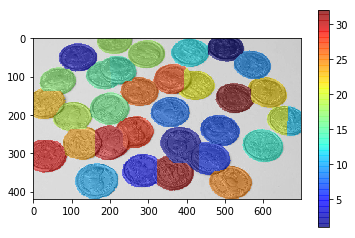

In [28]:
print('{} objetos identificados de um total de 32.'.format((np.unique(seg_im) > 0).sum()))
plt.imshow(gray_im, cmap='gray')
axs = plt.gca()
seg_im = shuffle_labels(seg_im).astype(float)
seg_im[seg_im == 0] = np.nan
p = axs.imshow(seg_im, cmap='jet', alpha=0.5)
plt.colorbar(p)